# Data Cleaning  

In [2]:
import pandas as pd

df = pd.read_csv('senegalcity.csv', encoding='utf-8') 

#Rename size column
df = df.rename(columns={'size': 'area'})

#Drop rows with incorrect value type  
df = df.loc[(df.rooms.str.isnumeric())]
df = df.loc[(df.area.str.isnumeric())]

df.rooms = df.rooms.astype('int64').replace({0: None})
df.area = df.area.astype('int64').replace({0: None})

# Creating 2 columns for neighbourhoods and cities
df[['neighbourhood','city']] = df.location.str.split("(",expand=True)
df['city'] = df['city'].str.replace(')','')
df['neighbourhood'] = df['neighbourhood'].str.strip()

#Majority of the ads are located in Dakar and Thiés so we are going to focus on these 2 cities 
df = df[df['city'].isin([u'Dakar',u'Thi\xe8s'])]

#Assign same neighbourhood value for properties not in a central area 
def classify_neighb(dataframe):
    for index, value in dataframe.neighbourhood.items():
        if value not in [u'Mermoz',u'Ouakam',u'Almadies',u'Sacr\xe9 C\x9cur',u'Sicap',u'Saly',u'Cit\xe9 Keur Gorgui']:
           dataframe.neighbourhood[index] = u'Other'
    return dataframe

df  = classify_neighb(df) 
 
# Create dataframes for rents and sales
df_rent = df.loc[(df.offer == 'LOCATION')].drop(['offer','last_update','location'], axis=1).set_index('reference')
df_sale = df.loc[(df.offer == 'VENTE')].drop(['offer','last_update','location'], axis=1).set_index('reference')

SyntaxError: cannot assign to function call (<ipython-input-2-b7aceb7c0b72>, line 27)

In [38]:
df_rent = df.loc[(df.offer == 'LOCATION')].drop(['offer','last_update','location'], axis=1).set_index('reference')

#Calculate monthly rent in FCFA and drop unit column
def monthly_rent(dataframe):
    for i in range(dataframe.shape[0]):
        unit = dataframe['unit'].str.lower().values[i]
        price = dataframe['price'].values[i]
        if unit == u'jour':
           dataframe['price'].values[i] = price*30
        if unit == u'ann\xe9e':
           dataframe['price'].values[i] = price//12
        if unit == u'semaine':
           dataframe['price'].values[i] = price*4
        dataframe['price'].values[i] = dataframe['price'].values[i]/1000
        
    dataframe = dataframe[(dataframe.price > 0)]  
    return dataframe.drop('unit', axis=1)

df_rent = monthly_rent(df_rent)
df_rent.sort_values(by=['price'],ascending=False)
 
    
#Keep flats and houses 
df_rent= df_rent[df_rent['type'].isin([u'Appartement', u'Villa'])]

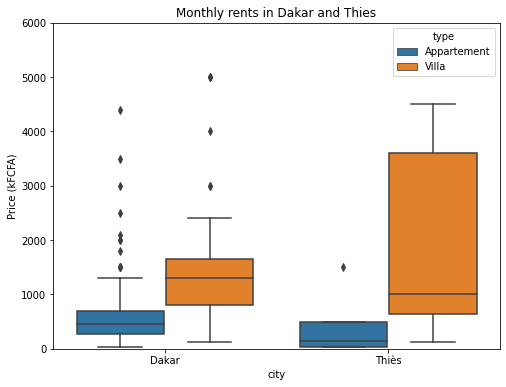

In [39]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize =(8,6))
plt.title("Monthly rents in Dakar and Thies")
a_plot = sns.boxplot(x = df_rent['city'], y= df_rent['price'], hue = df_rent['type'])
a_plot.set(ylim=(0, 6000))
plt.ylabel('Price (kFCFA)')
plt.show() 

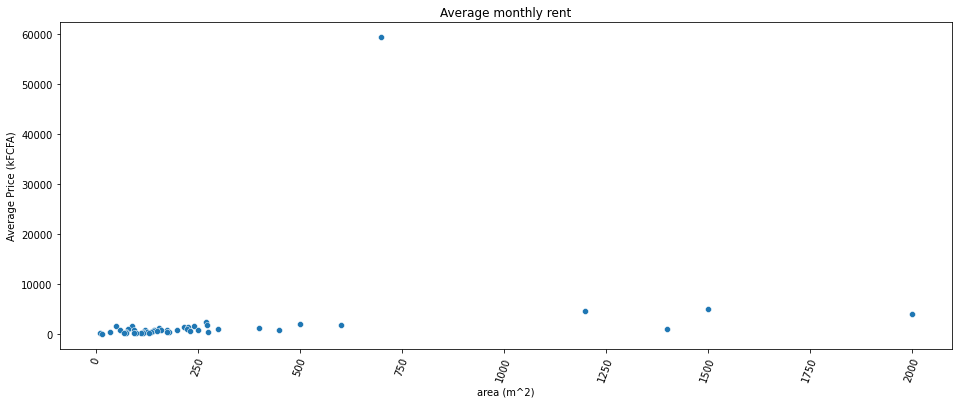

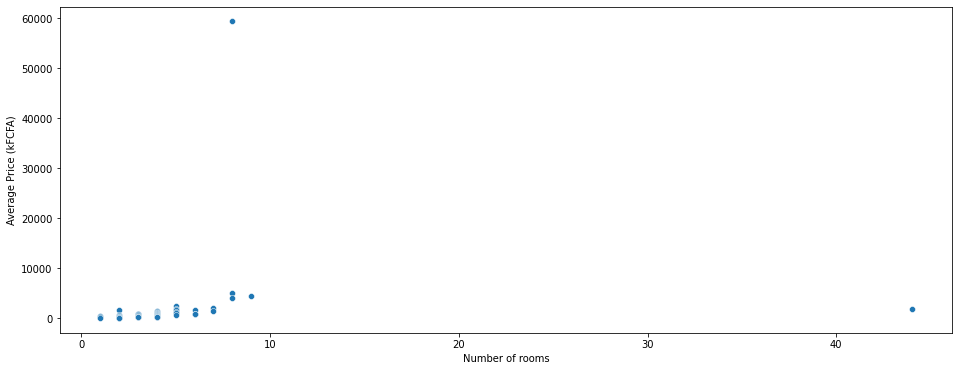

In [40]:
df_rent_area = df_rent.groupby('area').mean().sort_values('price', ascending = False) 
df_rent_area = df_rent_area.astype('int64')

plt.figure(figsize=(16,6))
plt.title("Average monthly rent")
sns.scatterplot(x = df_rent_area.index, y =df_rent_area['price'])
plt.xticks(rotation=70)
plt.ylabel('Average Price (kFCFA)')
plt.xlabel('area (m^2)')
plt.show()


plt.figure(figsize=(16,6)) 
sns.scatterplot(x = df_rent_area.rooms, y =df_rent_area['price'])
plt.ylabel('Average Price (kFCFA)')
plt.xlabel('Number of rooms')
plt.show()

In [41]:
df_rent = df_rent.loc[df_rent['price']!=df_rent['price'].max()] #Removing 1 outlier 


In [29]:
df_rent.to_csv('rent_data.csv',index = False)